<h1>Part 1: data preprocessing and cleaning<h1>

In [1]:
import pandas as pd
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell, Verbosity
import swifter
import spacy
from spacy.cli import download
from langdetect import detect
import importlib.resources
import matplotlib.pyplot as plt
import seaborn as sns

**Step 1: loading and exploring the data set**

"The DataSet consists of user reviews of ChatGPT, including Textual Feedback, Ratings, and Review Dates. The Reviews Range from brief comments to more detailed feedback by covering a wide range of user sentiments. The ratings are on a scale of 1 to 5, representing varying levels of Satisfaction. The dataset spans multiple months, providing a temporal dimension for analysis. Each review is accompanied by a timestamp, allowing for Time-Series analysis of sentiment trends."

source: https://www.kaggle.com/datasets/anandshaw2001/chatgpt-users-reviews

In [2]:
df = pd.read_csv("ChatGPT_Reviews.csv")
df.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,8/23/2024 19:30
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,8/23/2024 19:28
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,8/23/2024 19:22
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,8/23/2024 19:20
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,8/23/2024 19:20


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


In [4]:
df = df.drop_duplicates(subset='Review Id', keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193154 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    193154 non-null  object
 1   Review       193148 non-null  object
 2   Ratings      193154 non-null  int64 
 3   Review Date  193154 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.4+ MB


We removed 196727 - 193154 = 3573 duplicates. Moreover, we observe 6 missing reviews and we subsequently drop them from the dataframe, but beforehand we check the distribution of df["Ratings"],
so that we have a reference when preprocessing is complete.

**Plotting the ratings**

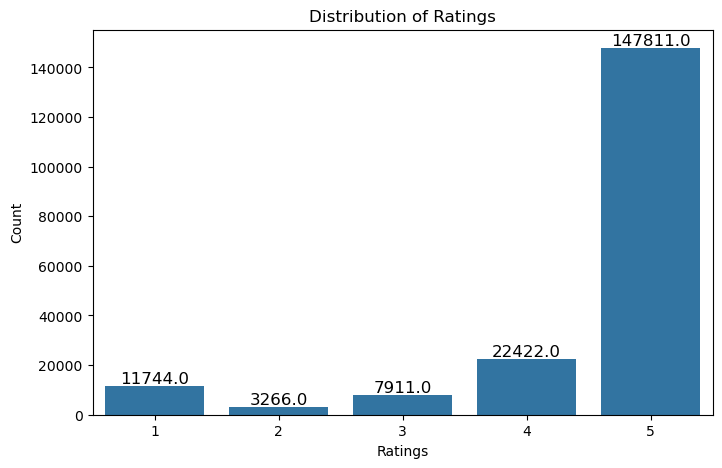

In [5]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df['Ratings'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')

plt.show()

**Dropping the missing reviews**

In [6]:
df = df.dropna()

**Step 2: removing non-English reviews**

In [7]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

df = df[df["Review"].swifter.apply(is_english)]

Pandas Apply:   0%|          | 0/193148 [00:00<?, ?it/s]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115688 entries, 4 to 196723
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    115688 non-null  object
 1   Review       115688 non-null  object
 2   Ratings      115688 non-null  int64 
 3   Review Date  115688 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.4+ MB


We have reduced the data frame by 196727 - 118011 = 78 716 records

**Step 3: translating emojis to English**

In [9]:
def convert_emojis_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

df["Review"] = df["Review"].apply(convert_emojis_to_text)

**Step 4: converting all reviews to lowercase**

In [10]:
df["Review"] = df["Review"].str.lower()

**Step 5: correcting spelling errors**

In [11]:
dictionary_path = importlib.resources.files("symspellpy") / "frequency_dictionary_en_82_765.txt"

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

sym_spell.load_dictionary(str(dictionary_path), term_index=0, count_index=1)

def correct_text(text):
    if isinstance(text, str):  
        suggestion = sym_spell.lookup_compound(text, max_edit_distance=2)
        return suggestion[0].term if suggestion else text
    return text 

df["Review"] = df["Review"].swifter.apply(correct_text)

Pandas Apply:   0%|          | 0/115688 [00:00<?, ?it/s]

**Step 6: removing stop words**

In [12]:
# Run only once!

# nltk.download('stopwords')
# nltk.download('punkt')

In [13]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df["Review"] = df["Review"].apply(remove_stopwords)

**Step 7: lemmatizing the reviews**

In [14]:
# Run only once!
# download("en_core_web_sm")

In [15]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df["Review"] = df["Review"].swifter.apply(lemmatize_text)

Pandas Apply:   0%|          | 0/115688 [00:00<?, ?it/s]

**Step 8: removing punctuation**

In [16]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

df["Review"] = df["Review"].apply(remove_punctuation)

**Step 9: checking and comparing the distribution of df["Ratings"]**

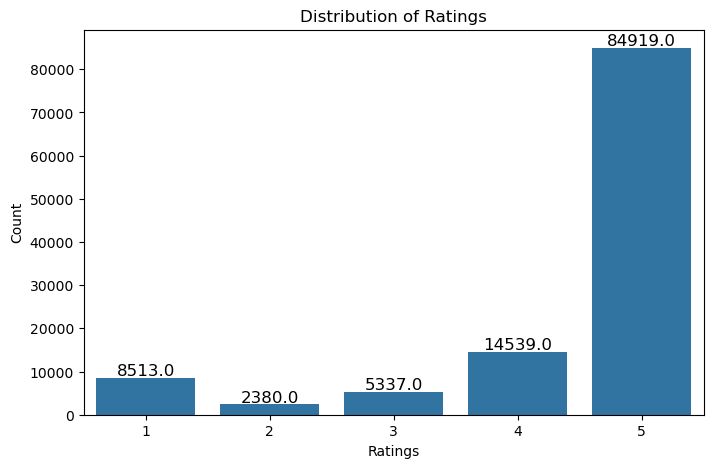

In [17]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df['Ratings'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')

plt.show()

**Ratings of value 1 preserved: 73%** <br>
**Ratings of value 2 preserved: 73%** <br>
**Ratings of value 3 preserved: 68%** <br>
**Ratings of value 4 preserved: 65%** <br>
**Ratings of value 5 preserved: 57%**

**Step 10: saving the cleaned ChatGPT reviews**

In [18]:
df.to_csv("ChatGPT_Reviews_Cleaned.csv", index=False)